In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.gridspec as gridspec

In [6]:
df = pd.read_csv('stroop_test.csv')
print("\n🔍 Data Overview:")
print(f"- Participants: {len(df)}")
print(f"- Accuracy range: {df['Accuracy(%)'].min()}%-{df['Accuracy(%)'].max()}%")
print(f"- Reaction time range: {df['ReactionTime(min)'].min()}-{df['ReactionTime(min)'].max()} min")
display(df.head(50))


🔍 Data Overview:
- Participants: 50
- Accuracy range: 31%-98%
- Reaction time range: 0.2-3.0 min


,Participant,Accuracy(%),ReactionTime(min)
0,1,36,0.48
1,2,75,2.33
2,3,89,2.42
3,4,69,1.32
4,5,56,0.32
5,6,89,2.57
6,7,75,1.55
7,8,98,2.95
8,9,35,0.26
9,10,67,1.45


# K-means Clustering: Determining Optimal K

/var/folders/rw/78tm6n2d2856gsqb273p1x2h0000gn/T/ipykernel_56925/329080744.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


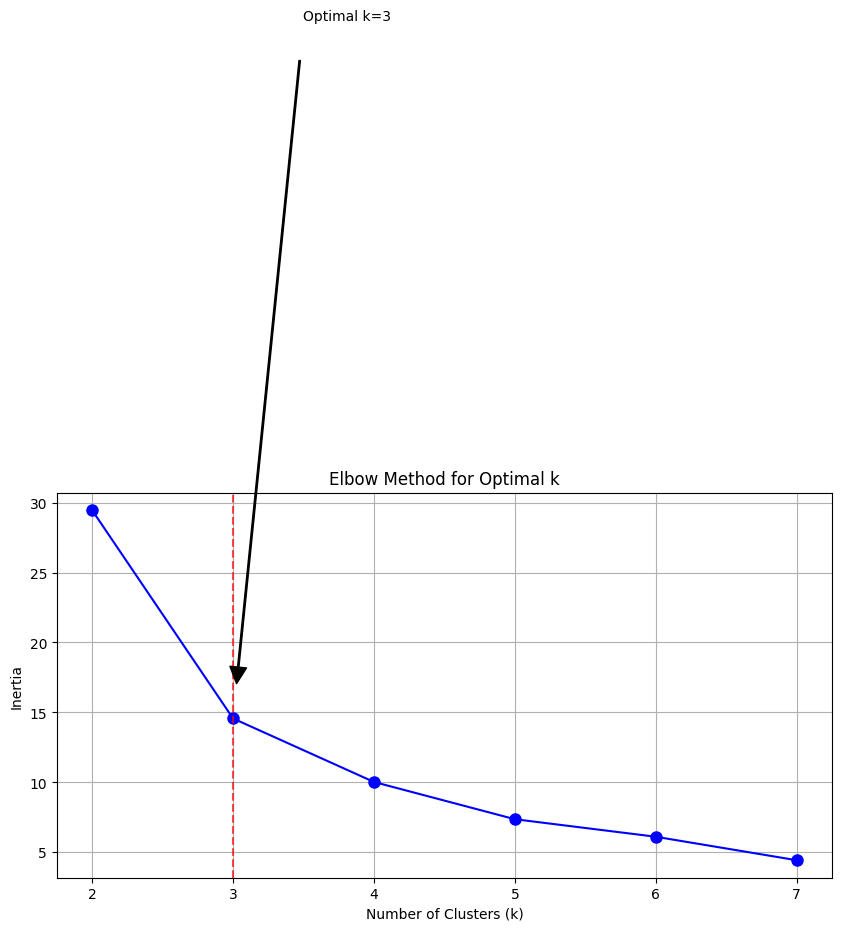

In [ ]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[['Accuracy(%)', 'ReactionTime(min)']])

# Elbow method for k
inertias = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

#  elbow curve
plt.figure(figsize=(10, 5))
plt.plot(k_range, inertias, 'bo-', markersize=8)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)

# k=3
plt.axvline(x=3, color='r', linestyle='--', alpha=0.7)
plt.annotate('Optimal k=3', xy=(3, inertias[1]), xytext=(3.5, inertias[1]+50),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1))

plt.grid(True)
plt.tight_layout()
plt.savefig('3_elbow_method.png')
plt.show()

# Apply K-means Clustering (k=3)


📊 Cluster Characteristics:


,Cluster,Acc Mean,Acc Std,Acc Min,Acc Max,Time Mean,Time Std,Time Min,Time Max,Count
0,0,61.555556,9.829261,45,75,1.345556,0.179287,1.01,1.58,18
1,1,39.461538,8.099541,31,56,0.506923,0.392288,0.20,1.56,13
2,2,86.894737,7.482533,73,98,2.347368,0.297916,1.78,3.00,19


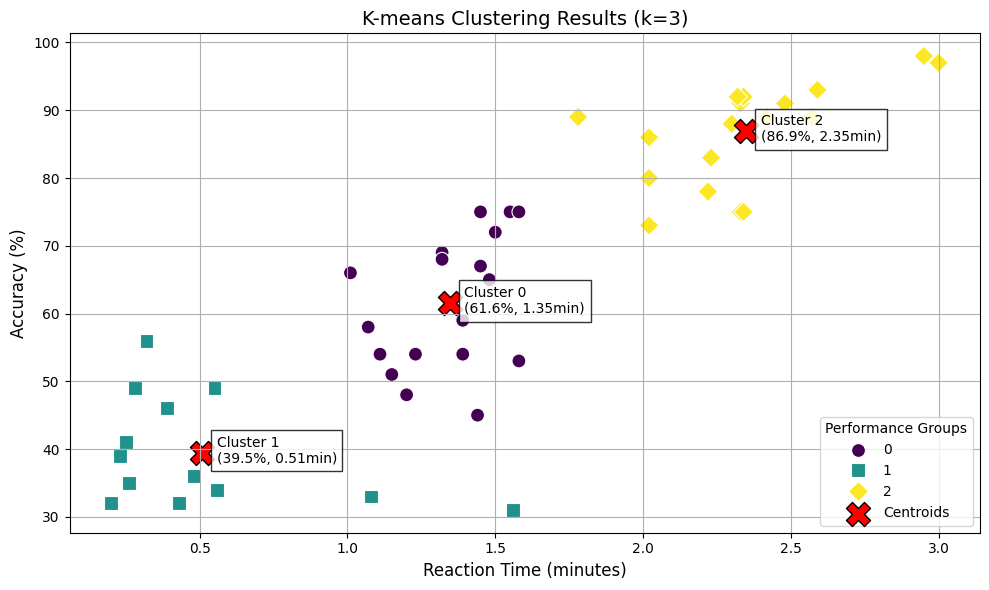

In [8]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Cluster centers in original scale
centers_original = scaler.inverse_transform(kmeans.cluster_centers_)
cluster_centers_df = pd.DataFrame(centers_original, columns=['Accuracy(%)', 'ReactionTime(min)'])
cluster_centers_df['Cluster'] = ['Low Acc/Fast', 'Medium', 'High Acc/Slow']

print("\n📊 Cluster Characteristics:")
cluster_summary = df.groupby('Cluster').agg({
    'Accuracy(%)': ['mean', 'std', 'min', 'max'],
    'ReactionTime(min)': ['mean', 'std', 'min', 'max'],
    'Participant': 'count'
}).reset_index()
cluster_summary.columns = ['Cluster', 'Acc Mean', 'Acc Std', 'Acc Min', 'Acc Max',
                           'Time Mean', 'Time Std', 'Time Min', 'Time Max', 'Count']
display(cluster_summary)

# Visualize clusters
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(data=df, x='ReactionTime(min)', y='Accuracy(%)', 
                          hue='Cluster', palette='viridis', s=100, 
                          style='Cluster', markers=['o', 's', 'D'])

# Plot centroids
plt.scatter(centers_original[:, 1], centers_original[:, 0], c='red', 
            s=300, marker='X', label='Centroids', edgecolor='black')

# Add cluster labels
for i, center in enumerate(centers_original):
    plt.text(center[1]+0.05, center[0]-1.5, f'Cluster {i}\n({center[0]:.1f}%, {center[1]:.2f}min)',
             fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

plt.title('K-means Clustering Results (k=3)', fontsize=14)
plt.xlabel('Reaction Time (minutes)', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend(title='Performance Groups', loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('4_kmeans_clusters.png')
plt.show()

# SVM Classification with Hyperplane Visualization


🎯 SVM Classification Accuracy: 1.00 (10/10 correct)


/Users/rokibulislam/Documents/GitHub/Rokibul_2111088642_CSE445/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/var/folders/rw/78tm6n2d2856gsqb273p1x2h0000gn/T/ipykernel_56925/1752483006.py:51: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(xx, yy, 'k-', linewidth=2, linestyle='--',


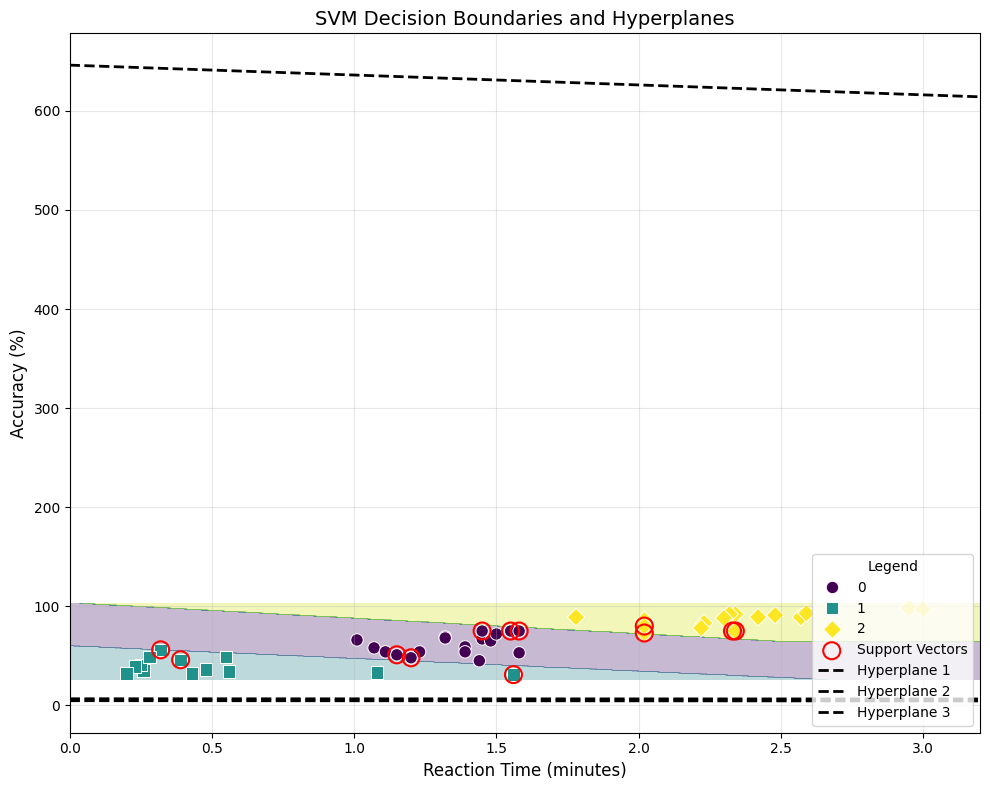

In [9]:
# Prepare data for classification
X = df[['Accuracy(%)', 'ReactionTime(min)']]
y = df['Cluster']

# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train SVM with linear kernel
svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(X_train, y_train)

# Evaluate performance
y_pred_svm = svm.predict(X_test)
svm_acc = accuracy_score(y_test, y_pred_svm)
print(f"\n🎯 SVM Classification Accuracy: {svm_acc:.2f} ({int(svm_acc*len(y_test))}/{len(y_test)} correct)")

# Create mesh grid for decision boundaries
x_min, x_max = X['ReactionTime(min)'].min() - 0.2, X['ReactionTime(min)'].max() + 0.2
y_min, y_max = X['Accuracy(%)'].min() - 5, X['Accuracy(%)'].max() + 5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

# Predict on mesh grid
Z = svm.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)

# Visualize decision boundaries
plt.figure(figsize=(10, 8))

# Plot decision regions
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')

# Plot data points
scatter = sns.scatterplot(data=df, x='ReactionTime(min)', y='Accuracy(%)', 
                          hue='Cluster', palette='viridis', s=80, 
                          style='Cluster', markers=['o', 's', 'D'])

# Highlight support vectors
plt.scatter(svm.support_vectors_[:, 1], svm.support_vectors_[:, 0], 
            s=150, facecolors='none', edgecolors='red', 
            linewidths=1.5, label='Support Vectors')

# Plot decision boundaries
for i, coef in enumerate(svm.coef_):
    w = coef
    a = -w[0] / w[1]
    xx = np.linspace(x_min, x_max)
    yy = a * xx - (svm.intercept_[i]) / w[1]
    plt.plot(xx, yy, 'k-', linewidth=2, linestyle='--', 
             label=f'Hyperplane {i+1}')

plt.title('SVM Decision Boundaries and Hyperplanes', fontsize=14)
plt.xlabel('Reaction Time (minutes)', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.legend(title='Legend', loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('5_svm_hyperplanes.png')
plt.show()

# Decision Tree Classification


🌳 Decision Tree Accuracy: 0.80 (8/10 correct)


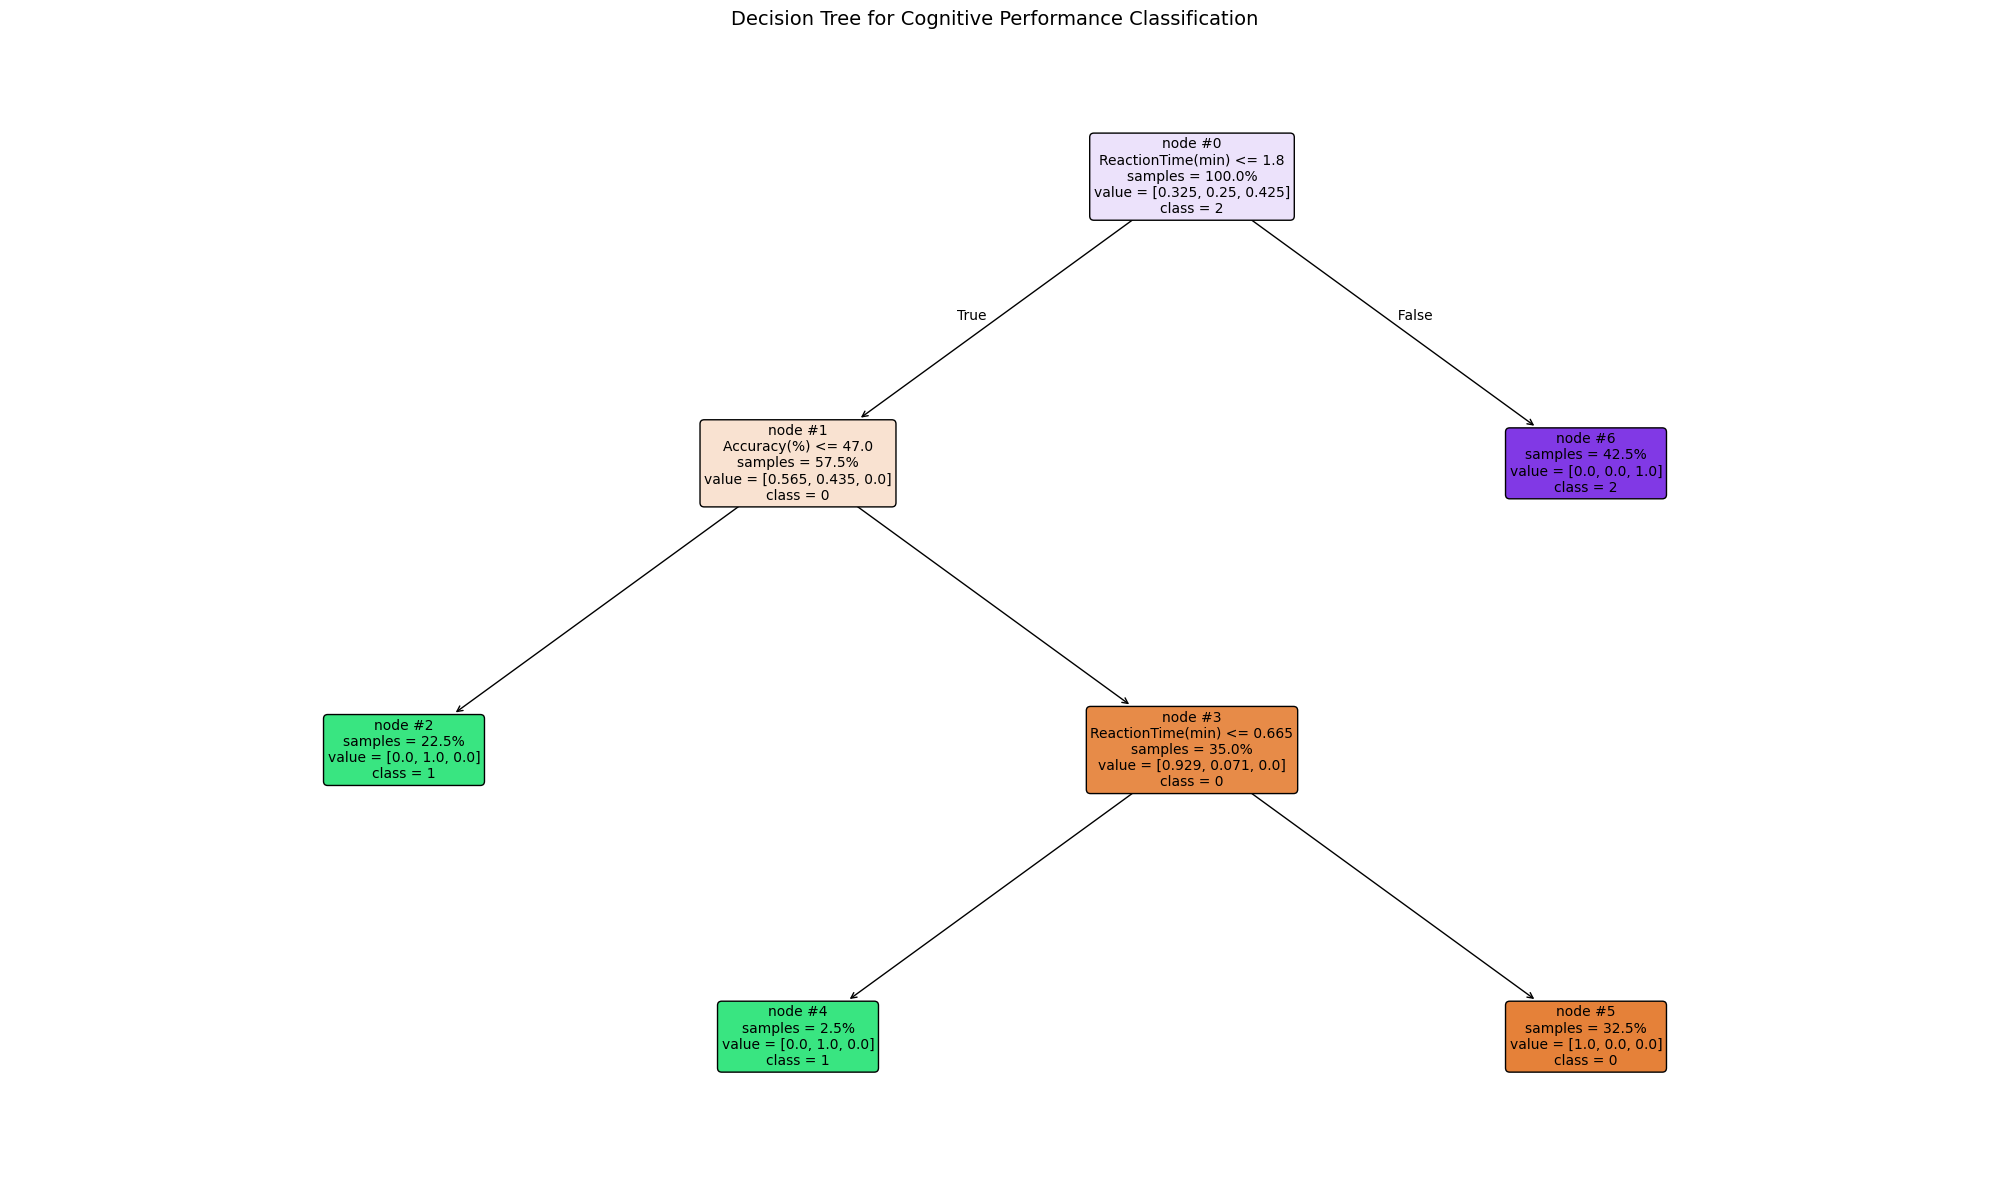

/var/folders/rw/78tm6n2d2856gsqb273p1x2h0000gn/T/ipykernel_56925/467790283.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_imp, y=feature_imp.index, palette='rocket')


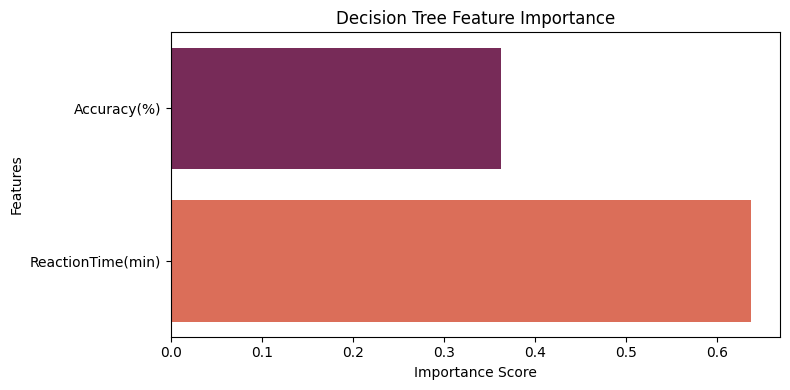

In [10]:
# Train decision tree classifier
dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X_train, y_train)

# Evaluate performance
y_pred_dt = dt.predict(X_test)
dt_acc = accuracy_score(y_test, y_pred_dt)
print(f"\n🌳 Decision Tree Accuracy: {dt_acc:.2f} ({int(dt_acc*len(y_test))}/{len(y_test)} correct)")

# Visualize decision tree
plt.figure(figsize=(20, 12))
plot_tree(dt, filled=True, feature_names=['Accuracy(%)', 'ReactionTime(min)'], 
          class_names=['0', '1', '2'], rounded=True, proportion=True,
          impurity=False, node_ids=True, fontsize=10)
plt.title('Decision Tree for Cognitive Performance Classification', fontsize=14)
plt.tight_layout()
plt.savefig('6_decision_tree.png')
plt.show()

# Feature importance analysis
feature_imp = pd.Series(dt.feature_importances_, index=X.columns)
plt.figure(figsize=(8, 4))
sns.barplot(x=feature_imp, y=feature_imp.index, palette='rocket')
plt.title('Decision Tree Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.savefig('7_feature_importance.png')
plt.show()

#  Confusion Matrices

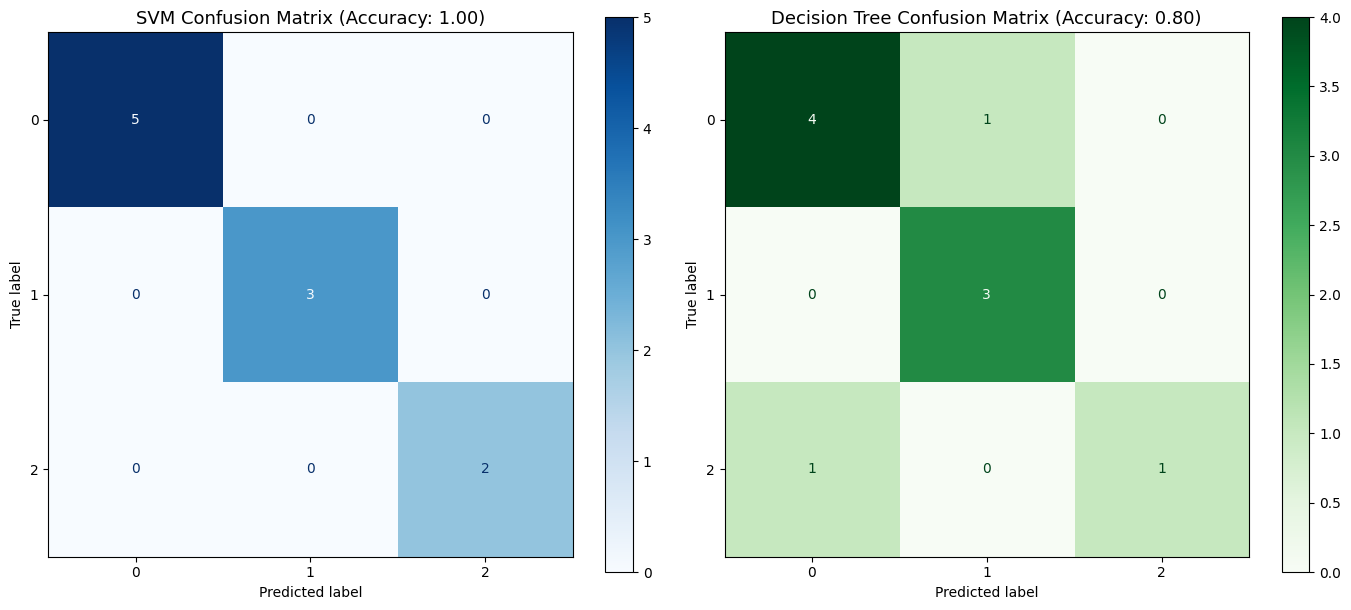

In [11]:
# Create figure for side-by-side comparison
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

# SVM Confusion Matrix
ax1 = plt.subplot(gs[0])
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, 
                                 display_labels=dt.classes_)
disp_svm.plot(ax=ax1, cmap='Blues', values_format='d')
ax1.set_title(f'SVM Confusion Matrix (Accuracy: {svm_acc:.2f})', fontsize=13)

# Decision Tree Confusion Matrix
ax2 = plt.subplot(gs[1])
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, 
                                display_labels=dt.classes_)
disp_dt.plot(ax=ax2, cmap='Greens', values_format='d')
ax2.set_title(f'Decision Tree Confusion Matrix (Accuracy: {dt_acc:.2f})', fontsize=13)

plt.tight_layout()
plt.savefig('8_confusion_matrices.png')
plt.show()


# Performance Group Analysis


🔍 Misclassified Participants by SVM: 0/50


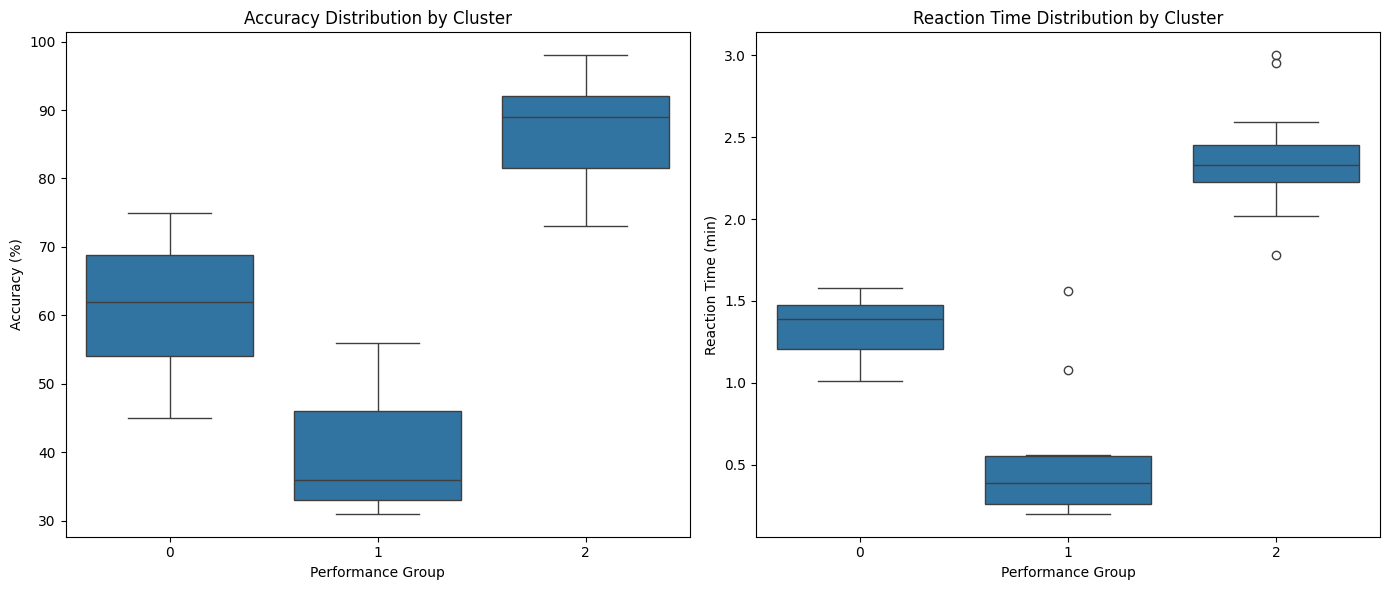

In [12]:
df['SVM_Prediction'] = svm.predict(X)
df['Tree_Prediction'] = dt.predict(X)

# Compare actual vs predicted clusters
misclassified = df[df['Cluster'] != df['SVM_Prediction']]
print(f"\n🔍 Misclassified Participants by SVM: {len(misclassified)}/{len(df)}")

if not misclassified.empty:
    print("Misclassified cases:")
    display(misclassified[['Participant', 'Accuracy(%)', 'ReactionTime(min)', 
                           'Cluster', 'SVM_Prediction']])

# Visualize group characteristics
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Accuracy comparison
sns.boxplot(data=df, x='Cluster', y='Accuracy(%)', ax=ax[0])
ax[0].set_title('Accuracy Distribution by Cluster')
ax[0].set_xlabel('Performance Group')
ax[0].set_ylabel('Accuracy (%)')

# Reaction time comparison
sns.boxplot(data=df, x='Cluster', y='ReactionTime(min)', ax=ax[1])
ax[1].set_title('Reaction Time Distribution by Cluster')
ax[1].set_xlabel('Performance Group')
ax[1].set_ylabel('Reaction Time (min)')

plt.tight_layout()
plt.savefig('9_group_comparison.png')
plt.show()


# Data showcase

/Users/rokibulislam/Documents/GitHub/Rokibul_2111088642_CSE445/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'SVM Decision Boundaries')

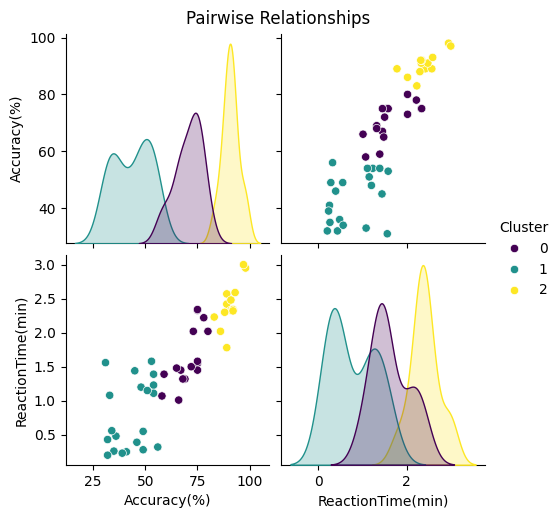

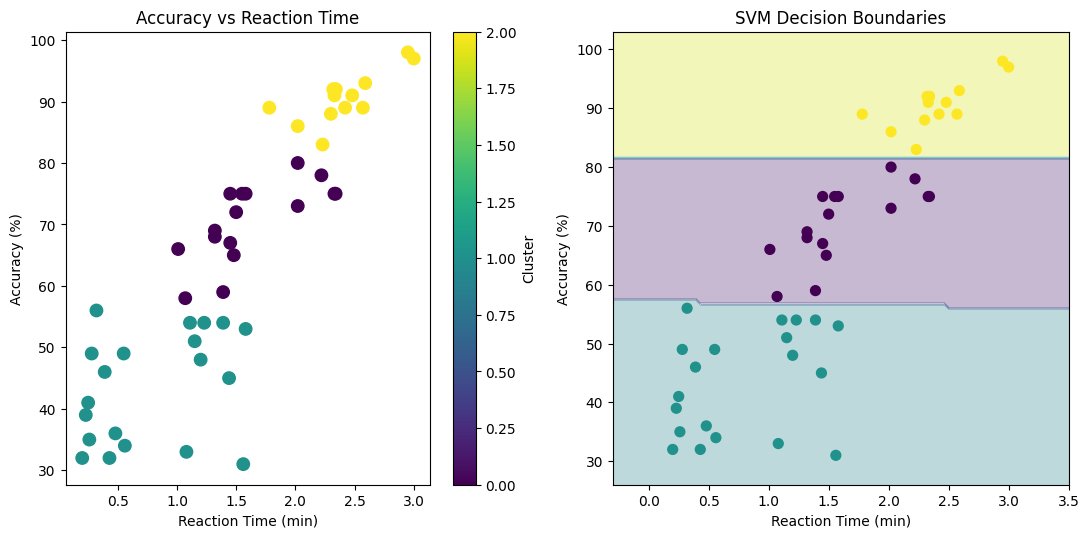

In [16]:


data = pd.read_csv('stroop_test.csv')

# clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(data[['Accuracy(%)', 'ReactionTime(min)']])
data['Cluster'] = clusters

# Train models
X = data[['Accuracy(%)', 'ReactionTime(min)']]
y = data['Cluster']

svm = SVC(kernel='linear', random_state=42)
svm.fit(X, y)

dt = DecisionTreeClassifier(max_depth=3, random_state=42)
dt.fit(X, y)

# Set up figure grid
plt.figure(figsize=(20, 20))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# 1. Histograms (plt.hist)
plt.subplot(3, 3, 1)
plt.hist(data['Accuracy(%)'], bins=15, color='skyblue', edgecolor='black')
plt.title('Accuracy Distribution')
plt.xlabel('Accuracy (%)')
plt.ylabel('Count')

plt.subplot(3, 3, 2)
plt.hist(data['ReactionTime(min)'], bins=15, color='salmon', edgecolor='black')
plt.title('Reaction Time Distribution')
plt.xlabel('Reaction Time (min)')
plt.ylabel('Count')

# 2. Enhanced Histograms (sns.histplot)
plt.subplot(3, 3, 3)
sns.histplot(data, x='Accuracy(%)', kde=True, color='teal')
plt.title('Accuracy Distribution with KDE')

plt.subplot(3, 3, 4)
sns.histplot(data, x='ReactionTime(min)', kde=True, color='coral')
plt.title('Reaction Time Distribution with KDE')

# 3. Boxplots (sns.boxplot)
plt.subplot(3, 3, 5)
sns.boxplot(data=data, y='Accuracy(%)', x='Cluster')
plt.title('Accuracy by Cluster')

plt.subplot(3, 3, 6)
sns.boxplot(data=data, y='ReactionTime(min)', x='Cluster')
plt.title('Reaction Time by Cluster')

# 4. Pairplot 

plt.close() 
pair = sns.pairplot(data, vars=['Accuracy(%)', 'ReactionTime(min)'], 
                   hue='Cluster', palette='viridis', diag_kind='kde')
pair.fig.suptitle('Pairwise Relationships', y=1.02)
pair.savefig('pairplot.png')

# 5. Scatter plot (plt.scatter)
plt.figure(figsize=(20, 20))  
plt.subplot(3, 3, 1)
plt.scatter(data['ReactionTime(min)'], data['Accuracy(%)'], 
           c=data['Cluster'], cmap='viridis', s=80)
plt.colorbar(label='Cluster')
plt.xlabel('Reaction Time (min)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Reaction Time')

# 6. Contour plot (plt.contourf) for SVM
plt.subplot(3, 3, 2)

x_min, x_max = data['ReactionTime(min)'].min()-0.5, data['ReactionTime(min)'].max()+0.5
y_min, y_max = data['Accuracy(%)'].min()-5, data['Accuracy(%)'].max()+5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                     np.linspace(y_min, y_max, 100))

# Predict on grid
Z = svm.predict(np.c_[yy.ravel(), xx.ravel()])
Z = Z.reshape(xx.shape)

# Plot
plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
plt.scatter(data['ReactionTime(min)'], data['Accuracy(%)'], 
           c=data['Cluster'], cmap='viridis', s=50)
plt.xlabel('Reaction Time (min)')
plt.ylabel('Accuracy (%)')
plt.title('SVM Decision Boundaries')



